In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

### Problem 3

In [35]:
from numba import njit

In [238]:
@njit
def ffi_model(drifts, a, x0, inhib_str, tau, dt=0.001, sigma=1., max_time=10):
    '''
    Simulate one FFI model run to get a response time.

    Parameters:
    -----------
    drifts: np.ndarray
        The drift rates (rates of information uptake)
    x0    : np.ndarray
        The starting points
    a     : float
        The boundary separation (decision threshold).
    inhib_str: float in [0, inf+)
        Strength of feedforward inhibition.
    tau   : float [0 , inf+)
        Non-decision time (additive constant)
    dt    : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    sigma : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time: float, optional (default: 10.)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and 
             corresponding accumulator x_i
    '''
    step = tau
    const = sigma*np.sqrt(dt)
    x = x0.copy()
    assert x.shape[0] == drifts.shape[0]
    J = x0.shape[0]

    # loop until max_time or any x >= a
    while step <= max_time and np.all(x < a):
        
        z = np.random.randn(J)
        for i in range(J):
            
            x[i] = max(x[i] + (drifts[i] - (inhib_str/(J-1))*(sum(drifts) - drifts[i])) * dt + const*z[i]
                       , 0)
            
        # increment step size
        step += dt
    
    return (round(step, 3), x.argmax())

In [239]:
@njit
def simulate_ffi(n_sim, drifts, a, x0, inhib_str, tau, dt=0.001, sigma=1., max_time=10):
    '''
    Perform multiple simulations of FFI model.
    
    Parameters:
    -----------
    n_sim: int [1, +inf)
        Number of simulations to run.
    **params: dict
        Parameters for FFI model.
    
    Returns:
    --------
    sim_res: np.ndarray
        Collection of results from FFI model.
    '''
    sim_res = np.zeros((n_sim, 2))
    for i in range(n_sim):
        # njit does not complain if assigned in this way
        t, c = ffi_model(drifts, a, x0, inhib_str, tau, dt, sigma, max_time)
        sim_res[i, 0] = t
        sim_res[i, 1] = c
        
    return sim_res

In [248]:
def visualize_ffi_trials(sim, num_acc, fontsize=16):
    '''
    Create histogram plots FFI simulations.
    
    Parameters:
    -----------
    sim: np.ndarray
        Collection of results from FFI model.
    fontsize: int
        Title and x-axis fontsize.
    
    Returns:
    --------
    ax: Axes
        Matplotlib Axes object visualizing simulation data.
    '''
    # creater figure
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.despine(ax=ax)
    # plot histogram
    for i in range(num_acc.shape[0]):
        acc = sim[sim[:, 1] == i][:, 0]
        sns.histplot(acc, label=f'Alternative {i + 1}, $\mu$ = {round(np.mean(acc), 3)}')
    # set labels and axes labels
    ax.legend()
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_title('Feedforward Inhibition Model', fontsize=fontsize)
    ax.set_xlabel('Response Times', fontsize=fontsize)

    return ax

In [249]:
drifts = np.array([0.5, 0.5, 0.5, 0.5])
x0 = np.array([0., 0., 0., 0.])

<Axes: title={'center': 'Feedforward Inhibition Model'}, xlabel='Response Times'>

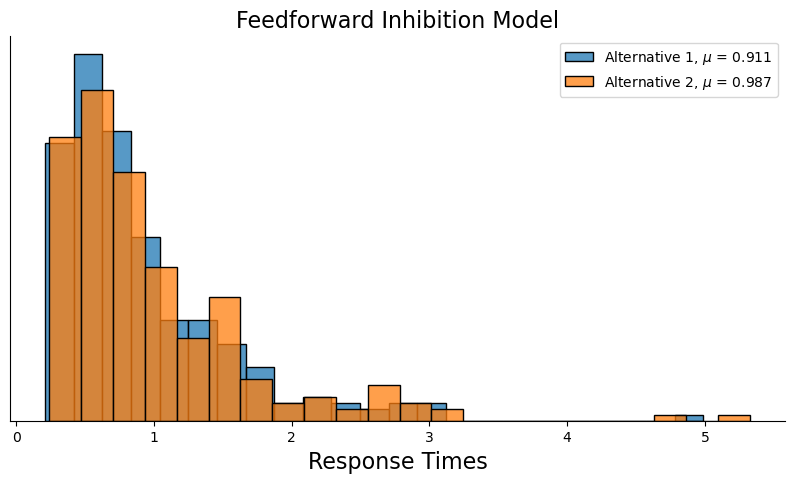

In [254]:
# 2 alternatives
params = {
    'drifts': drifts[0:2],
    'x0': x0[0:2], 
    'a': 1., 
    'inhib_str': 2.0, 
    'tau': 0.1,
}
sim = simulate_ffi(500, **params)
ax = visualize_ffi_trials(sim, num_acc=params['drifts'])
ax


<Axes: title={'center': 'Feedforward Inhibition Model'}, xlabel='Response Times'>

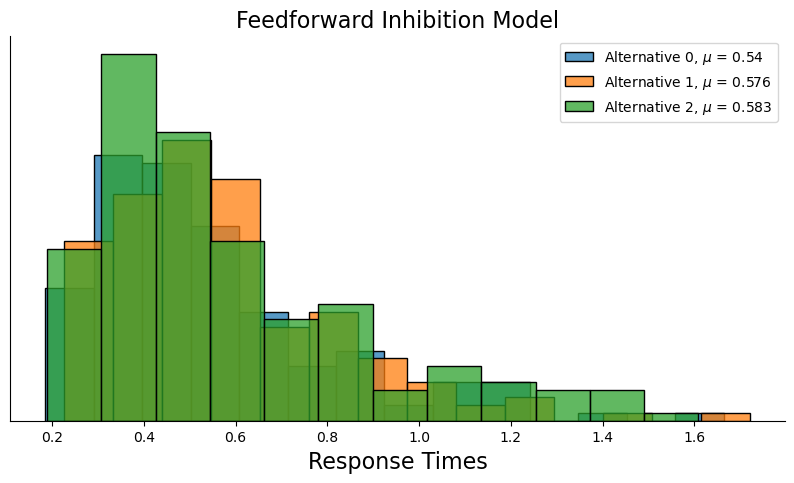

In [202]:
# 3 alternatives
params = {
    'drifts': drifts[0:3],
    'x0': x0[0:3], 
    'a': 1., 
    'inhib_str': 1., 
    'tau': 0.1,
}
sim = simulate_ffi(500, **params)
ax = visualize_ffi_trials(sim, num_acc=params['drifts'])
ax

<Axes: title={'center': 'Feedforward Inhibition Model'}, xlabel='Response Times'>

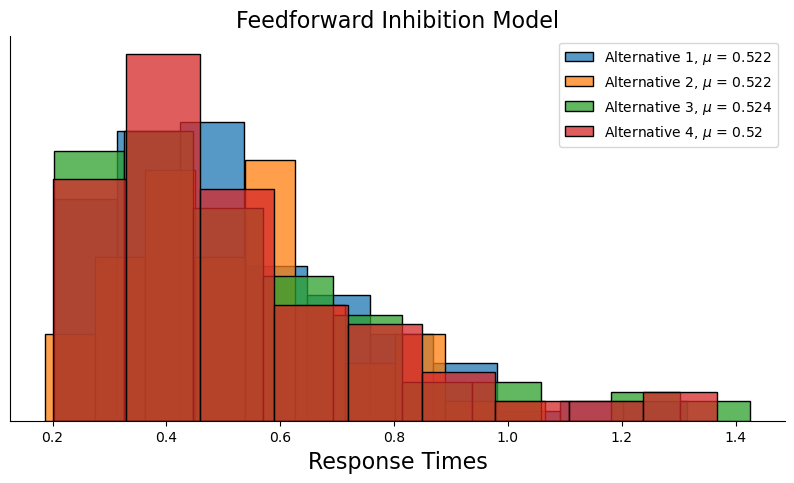

In [257]:
# 4 alternatives
params = {
    'drifts': drifts[0:4],
    'x0': x0[0:4], 
    'a': 1., 
    'inhib_str': 1.0, 
    'tau': 0.1,
}
sim = simulate_ffi(500, **params)

ax = visualize_ffi_trials(sim, num_acc=params['drifts'])
ax

numba works for simlation, but specific code arrangement are needed to make njit compile

### Problem 6

In [264]:
N = 200
alpha = 3.5
sigma = 2.
slope = 2.
x = np.random.normal(size=N)
y = alpha + slope*x + sigma*np.random.normal(size=N)

In [259]:
slope_code = '''
data {
    int<lower=1> N;
    array[N] real y;
    array[N] real x;
}
parameters {
    real<lower=0> sigma_sqr;
    real a;
    real beta;
}
transformed parameters {
    real sigma;
    sigma = sqrt(sigma_sqr);
}
model {
    // Priors
    sigma_sqr ~ inv_gamma(1, 1);
    a ~ normal(0, 10);
    beta ~ normal(0, 10);

    // Likelihood
    for (n in 1:N) {
        y[n] ~ normal(a + beta*x[n], sigma);
    }
}
'''

In [260]:
# Prepare data in Stan friendly format
data_dict = {
    'N': N,
    'y': y, 
    'x': x,
}

# Compile model
model = stan.build(slope_code, data=data_dict)

Building...



Building: found in cache, done.

In [261]:
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=2500)

Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000819 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000355 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.55 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000218 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000187 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.87 seconds.
  Adjust your expectations accordingly!


In [262]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_sqr,4.254,0.428,3.492,5.090,0.004,0.003,9461.0,7565.0,1.0
a,3.350,0.146,3.079,3.626,0.002,0.001,9420.0,7231.0,1.0
beta,2.118,0.161,1.826,2.432,0.002,0.001,10574.0,7608.0,1.0
sigma,2.060,0.103,1.875,2.262,0.001,0.001,9461.0,7565.0,1.0


the estimated parameters are close to the set parameters. 94% highest hdi is consistent with mean and std. relative low error between montecarlo samples. ess metrics are close to total number of samples. the model closely approximated the given distribution. r_hat = 1 for all parameters, suggests model converged to the target distribution effectively.

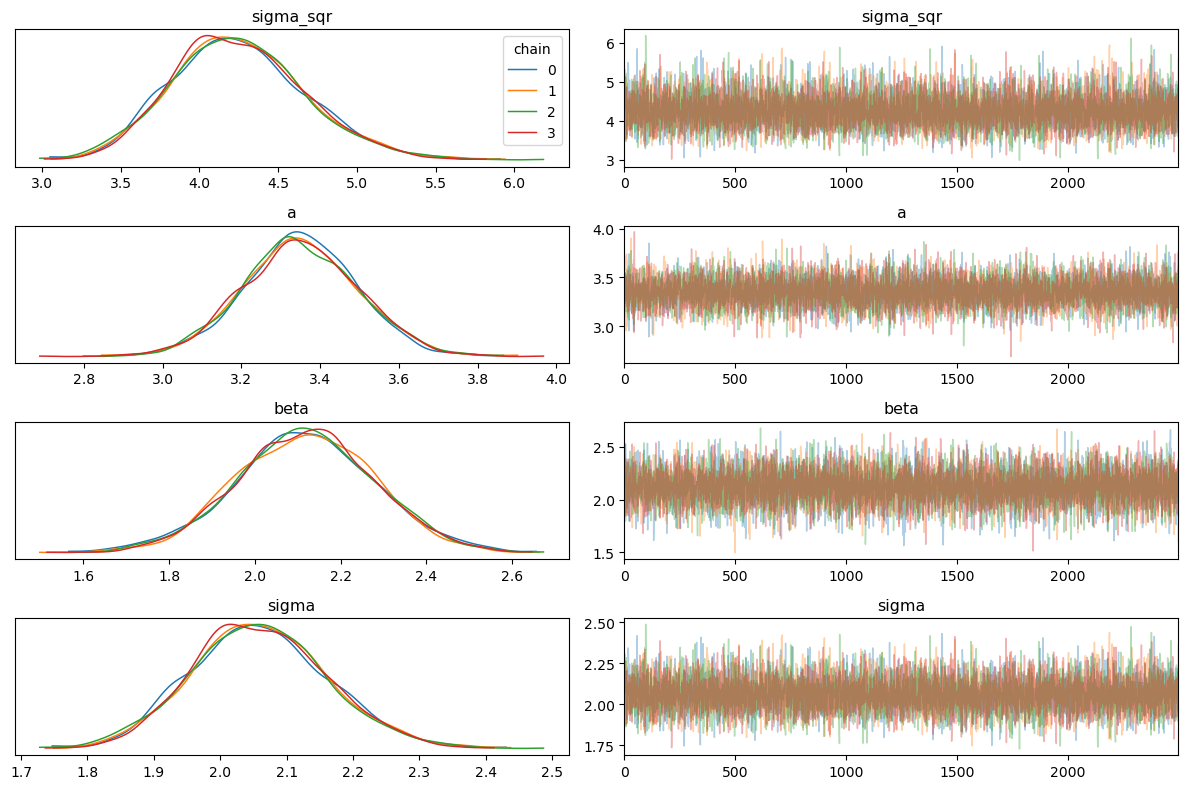

In [263]:
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

In [265]:
N = 2000
alpha = 3.5
sigma = 2.
slope = 2.
x = np.random.normal(size=N)
y = alpha + slope*x + sigma*np.random.normal(size=N)

# Prepare data in Stan friendly format
data_dict = {
    'N': N,
    'y': y, 
    'x': x,
}
# Compile model
model = stan.build(slope_code, data=data_dict)

fit = model.sample(num_chains=4, num_warmup=1000, num_samples=2500)
az.summary(fit)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   1% (200/14000)
Sampling:   3% (400/14000)
Sampling:   5% (700/14000)
Sampling:   6% (900/14000)
Sampling:  11% (1500/14000)
Sampling:  15% (2100/14000)
Sampling:  38% (5300/14000)
Sampling:  61% (8600/14000)
Sampling:  81% (11300/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.003615 seconds
  1000 transitions using 10 leapfrog steps per transition would take 36.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000654 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.54 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_uorb6khn/model_e5lexlz2.stan', line 24, column 8 to column 44)
  If

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_sqr,4.110,0.130,3.863,4.351,0.001,0.001,9765.0,8036.0,1.0
a,3.452,0.045,3.369,3.535,0.000,0.000,11772.0,8430.0,1.0
beta,1.891,0.044,1.811,1.974,0.000,0.000,9398.0,7033.0,1.0
sigma,2.027,0.032,1.968,2.088,0.000,0.000,9765.0,8036.0,1.0


### Problem 7

In [266]:
data = pd.read_csv('sample_response_times.csv', delimiter=';')
data.shape[0]

300

In [276]:
diff_code = '''
data {
    int<lower=1> N;
    array[N] real<lower=0> y;
    array[N] int<lower=1, upper=2> condition;
    array[N] int<lower=0, upper=1> choice;
}

parameters {
    // condition 1
    real<lower=0> v;
    real<lower=0> a;
    real<lower=0, upper=1> beta;
    real<lower=0> tau;
    // condition 2
    real<lower=0> v2;
    real<lower=0> a2;
    real<lower=0, upper=1> beta2;
    real<lower=0> tau2;
}

model {
    // Priors
    v ~ gamma(3, 1);
    a ~ gamma(3, 1);
    beta ~ beta(2, 2);
    tau ~ gamma(2, 1);

    v2 ~ gamma(3, 1);
    a2 ~ gamma(3, 1);
    beta2 ~ beta(2, 2);
    tau2 ~ gamma(2, 1);

    // Likelihood
    for (n in 1:N) {
        // Condition 1
        if (condition[n] == 1) {
            if (choice[n] == 1) {
                y[n] ~ wiener(a, tau, beta, v);
            }
            else {
                y[n] ~ wiener(a, tau, 1-beta, -v);
            }
        }
        // Condition 2
        if (condition[n] == 2) {
            if (choice[n] == 1) {
                y[n] ~ wiener(a2, tau2, beta2, v2);
            }
            else {
                y[n] ~ wiener(a2, tau2, 1-beta2, -v2);
            }
        }
    }
}
'''

In [277]:
rt = data['rt']
choice = data['choice']
condition = data['condition']

In [278]:
# Prepare data in Stan friendly format
data_dict = {
    'N': data.shape[0],
    'y': rt.to_numpy(), 
    'choice': choice.to_numpy(dtype=int),
    'condition': condition.to_numpy(dtype=int),
}

# Compile model
model2 = stan.build(diff_code, data=data_dict)

Building...



Building: found in cache, done.

In [279]:
fit = model2.sample(num_chains=4, num_warmup=1000, num_samples=2500)

Sampling:   0%
Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   0% (4/14000)
Sampling:   1% (103/14000)
Sampling:   1% (202/14000)
Sampling:   2% (301/14000)
Sampling:   3% (400/14000)
Sampling:   4% (500/14000)
Sampling:   4% (600/14000)
Sampling:   5% (700/14000)
Sampling:   6% (800/14000)
Sampling:   6% (900/14000)
Sampling:   7% (1000/14000)
Sampling:   8% (1100/14000)
Sampling:   9% (1200/14000)
Sampling:   9% (1300/14000)
Sampling:  10% (1400/14000)
Sampling:  11% (1500/14000)
Sampling:  11% (1600/14000)
Sampling:  12% (1700/14000)
Sampling:  13% (1800/14000)
Sampling:  14% (1900/14000)
Sampling:  14% (2000/14000)
Sampling:  15% (2100/14000)
Sampling:  16% (2200/14000)
Sampling:  16% (2300/14000)
Sampling:  17% (2400/14000)
Sampling:  18% (2500/14000)
Sampling:  19% (2600/14000)
Sampling:  19% (2700/14000)
Sampling:  20% (2800/14000)
Sampling:  21% (2900/14000)
Sampling:  21% (3000/14000)
Sampling:  22% (3100/14000)
Sampling:  23% (3200/14000

In [280]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,2.203,0.308,1.621,2.774,0.004,0.003,7019.0,6333.0,1.0
a,0.914,0.049,0.823,1.005,0.001,0.000,8354.0,6813.0,1.0
beta,0.613,0.037,0.541,0.680,0.000,0.000,6166.0,6281.0,1.0
tau,0.399,0.004,0.392,0.406,0.000,0.000,6358.0,5158.0,1.0
v2,0.760,0.218,0.341,1.160,0.002,0.002,7631.0,5483.0,1.0
a2,0.819,0.032,0.760,0.880,0.000,0.000,8184.0,6391.0,1.0
beta2,0.450,0.026,0.401,0.498,0.000,0.000,8521.0,7158.0,1.0
tau2,0.404,0.004,0.396,0.411,0.000,0.000,8276.0,6462.0,1.0


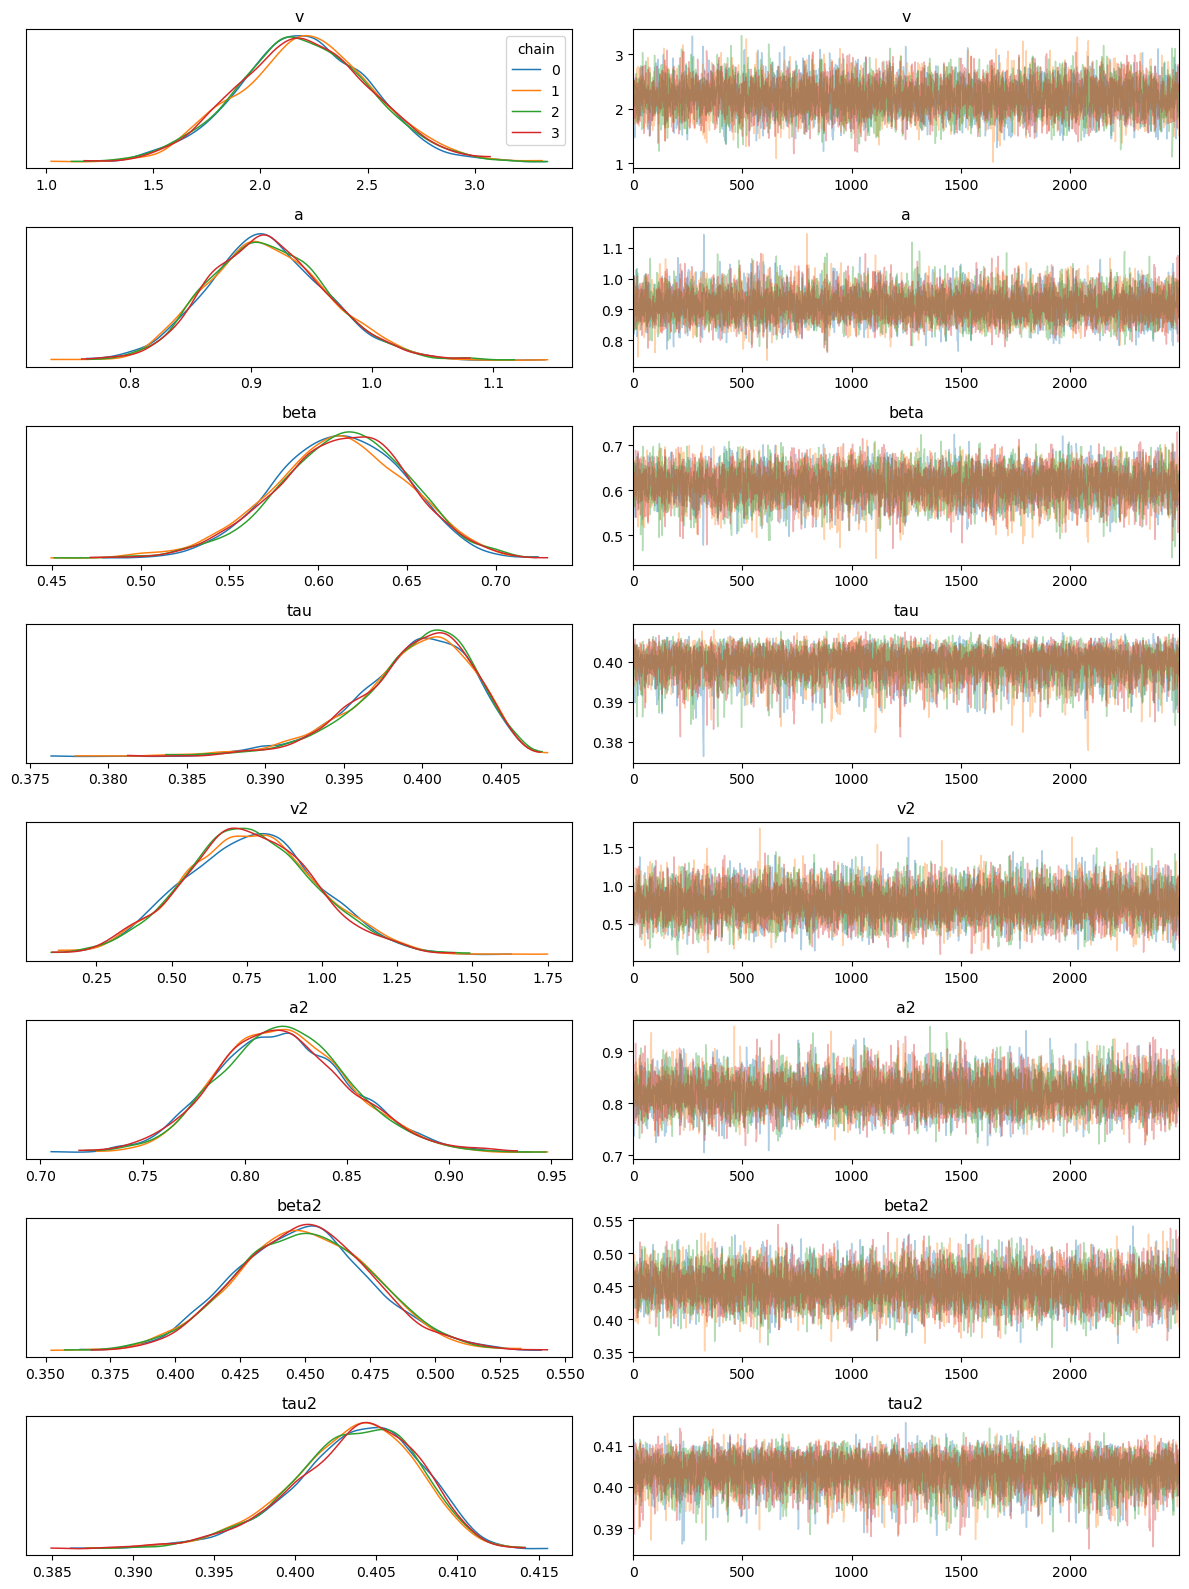

In [281]:
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()

v is stepper than v2. this indicates decision from v was made faster than v2. v is likely from condition 1 because searching accross 10 faces is faster than searching accross 100 faces.